<a href="https://colab.research.google.com/github/WhiteHum/Medical-AI-Deep-Learning-Drug-Toxicitiy-Prediction-/blob/main/06_Covid_CT_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **공유폴더에 접근하기**

In [2]:
# 구글 드라이브ㅡ 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/패스트캠퍼스/Part2/Part_2/실습/06.Covid_CT_image_classification/Covid_Dataset.zip

Archive:  /content/drive/MyDrive/패스트캠퍼스/Part2/Part_2/실습/06.Covid_CT_image_classification/Covid_Dataset.zip
   creating: Covid_Dataset/
  inflating: __MACOSX/._Covid_Dataset  
   creating: Covid_Dataset/Covid_Train/
  inflating: __MACOSX/Covid_Dataset/._Covid_Train  
  inflating: Covid_Dataset/.DS_Store  
  inflating: __MACOSX/Covid_Dataset/._.DS_Store  
   creating: Covid_Dataset/Covid_Test/
  inflating: __MACOSX/Covid_Dataset/._Covid_Test  
   creating: Covid_Dataset/Covid_Valid/
  inflating: __MACOSX/Covid_Dataset/._Covid_Valid  
   creating: Covid_Dataset/Covid_Train/1_CT_COVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Train/._1_CT_COVID  
   creating: Covid_Dataset/Covid_Train/0_CT_NonCOVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Train/._0_CT_NonCOVID  
   creating: Covid_Dataset/Covid_Test/1_CT_COVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Test/._1_CT_COVID  
   creating: Covid_Dataset/Covid_Test/0_CT_NonCOVID/
  inflating: __MACOSX/Covid_Dataset/Covid_Test/._0_C

In [4]:
root_dir = '/content/Covid_Dataset/'

# **데이터 준비 및 전처리**

### **이미지 예시 출력**

In [5]:
import random
import os
import cv2
import matplotlib.pyplot as plt

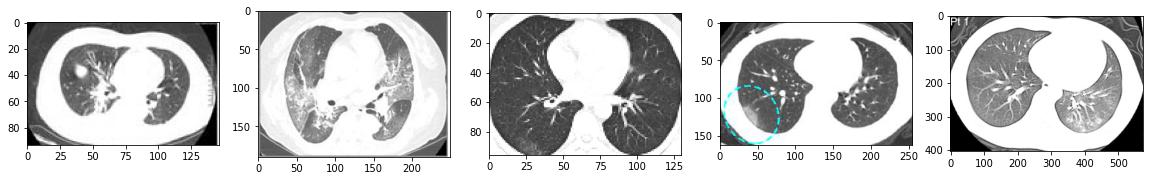

In [6]:
# Train data의 COVID 데이터 랜덤하게 5개 확인하기 (데이터 확인용)

covid_train_path = os.path.join(root_dir, 'Covid_Train', '1_CT_COVID')

covid_files = [os.path.join(covid_train_path, x) for x in os.listdir(covid_train_path)]
covid_images = [cv2.imread(x) for x in random.sample(covid_files, 5)]

# 이미지를 어떤 사이즈로 보여줄 것인지, 몇 열로 보여줄 것인지 설정하는 곳
plt.figure(figsize = (20, 10))
columns = 5

for i, image in enumerate(covid_images) :
  plt.subplot(len(covid_images) / columns + 1, columns, i +1)
  plt.imshow(image)


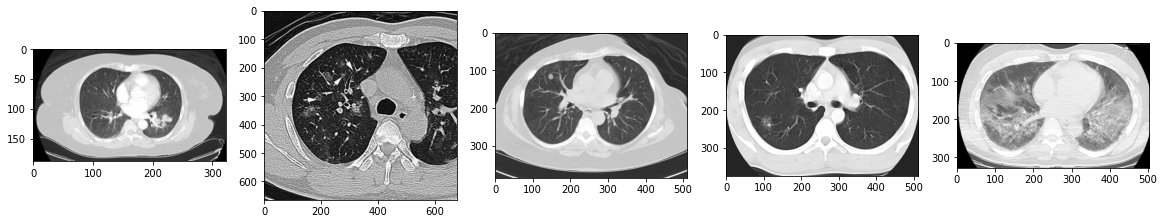

In [8]:
# Train data의 Non-COVID 데이터 랜덤하게 5개 확인하기 (데이터 확인용)

covid_train_path = os.path.join(root_dir, 'Covid_Train', '0_CT_NonCOVID')

covid_files = [os.path.join(covid_train_path, x) for x in os.listdir(covid_train_path)]
covid_images = [cv2.imread(x) for x in random.sample(covid_files, 5)]

# 이미지를 어떤 사이즈로 보여줄 것인지, 몇 열로 보여줄 것인지 설정하는 곳
plt.figure(figsize = (20, 10))
columns = 5

for i, image in enumerate(covid_images) :
  plt.subplot(len(covid_images) / columns + 1, columns, i +1)
  plt.imshow(image)


# **데이터 분포 확인**

In [9]:
import os

In [10]:
def print_files_in_dir(root_dir, prefix):
  files = os.listdir(root_dir)
  lab = ['COVID', 'Non-COVID']
  for i, file in enumerate(files):
    path = os.path.join(root_dir, file)
    file_list = os.listdir(path)
    print(f'{prefix} 데이터의 {lab[i]}의 수 : {len(file_list)}')

In [11]:
phase = 'Train'
print_files_in_dir(root_dir + f'Covid_{phase}', phase)
print()

phase = 'Valid'
print_files_in_dir(root_dir + f'Covid_{phase}', phase)
print()

phase = 'Test'
print_files_in_dir(root_dir + f'Covid_{phase}', phase)
print()

Train 데이터의 COVID의 수 : 234
Train 데이터의 Non-COVID의 수 : 191

Valid 데이터의 COVID의 수 : 58
Valid 데이터의 Non-COVID의 수 : 60

Test 데이터의 COVID의 수 : 105
Test 데이터의 Non-COVID의 수 : 98



# **데이터 전처리**

In [12]:
# 필요한 모듈 불러오기

import numpy as np
import torch
from torchvision import datasets, transforms
import torch.utils.data as data

In [13]:
# 디바이스 설정 (GPU 사용 가능하면 GPU 사용 하도록)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

random_seed = 2022

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

np.random.seed(random_seed)
random.seed(random_seed)

# 아래 코드는 사실 별로 필요가 없는 코드라고 함
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
# 데이터 transform 적용하기

normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
image_transforms = {
    'train' : transforms.Compose([
    transforms.Resize(256),

    # data augmentation
    transforms.RandomResizedCrop((224), scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize]),


    # 224 x 224 사이즈가 대중적으로 사용된다고 함
    # pytorch는 tensor로 변환해주어야 한다고 함
    'valid' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
        ])

}

In [15]:
train_dataset_folder = root_dir + 'Covid_Train'
valid_dataset_folder = root_dir + 'Covid_Valid'
test_dataset_folder = root_dir + 'Covid_Test'

In [16]:
train_dataset = datasets.ImageFolder(root = train_dataset_folder, transform = image_transforms['train'])
valid_dataset = datasets.ImageFolder(root = valid_dataset_folder, transform = image_transforms['valid'])
test_dataset = datasets.ImageFolder(root = test_dataset_folder, transform = image_transforms['valid'])

In [17]:
# DatLoader을 위한 hyperparameter 설정


# batch_size = 사진 몇개씩 담을 것인가
# shuffle = 사진을 무작위로 섞을 것인가
# drop_last = 소수점 아래 자리들을 버릴 것인가(빨리 돌려야 한다면 True/안그래도 괜찮다면 False)
train_params = {
    'batch_size' : 64,
    'shuffle': True,
    'num_workers' : 1,
    'drop_last' : False
}

valid_params = {
    'batch_size' : 64,
    'shuffle': False,
    'num_workers' : 1,
    'drop_last' : False
}

In [18]:
train_loader = data.DataLoader(train_dataset, **train_params)
valid_loader = data.DataLoader(valid_dataset, **valid_params)
test_loader = data.DataLoader(test_dataset, **valid_params)

In [19]:
# Train DataLoader 데이터 확인해 보기

for x, y in train_loader :
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [20]:
# Valid DataLoader 데이터 확인해 보기

for x, y in valid_loader :
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 3, 224, 224])
torch.Size([64])


# **모델 만들기**

In [21]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [22]:
# 모델 설정 값

config = {
    # Classifier 설정
    'cls_hidden_dims' : []
}

In [23]:
# pretrain 된 ResNet을 이용해 CT image embedding
class CovidResNet(nn.Module):
  def __init__(self):
    # base_model : resnet18 /resnet50
    # config : 모델 설정 값
      super(CovidResNet, self).__init__()
      model = models.resnet50(pretrained = True)
      num_ftrs = model.fc.in_features
      self.num_ftrs = num_ftrs
      
      for name, param in model.named_parameters():
        if 'layer2' in name:
          break
        param.requires_grad = False
      self.features = nn.Sequential(* list(model.children())[:-1])

  def forward(self, x):
    x = self.features(x)
    b = x.size(0)
    x = x.view(b, -1)

    return x


# **Model 선택 가능**

In [24]:
model_image = CovidResNet()
model_image

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

CovidResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [25]:
# 임베딩 된 feature을 이용해 classification
class Classifier(nn.Sequential):
  def __init__(self, model_image, **config):

    # model_image : image emedding 모델
    # config : 모델 설정값

    super(Classifier, self).__init__()
    
    self.model_image = model_image # image 임베딩 모델
    self.input_dim = model_image.num_ftrs # image feature 사이즈
    self.dropout = nn.Dropout(0.1) # dropout 적용

    self.hidden_dims = config['cls_hidden_dims'] #classifier hidden dimensions
    layer_size = len(self.hidden_dims) + 1 #hidden layer 개수
    dims = [self.input_dim] + self.hidden_dims + [2]

    self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifier layers

  def forward (self, v):
    # Drug/portein 임베딩
    v_i = self.model_image(v) # batch_szie x hidden_dim
    for i, I in enumerate(self.predictor):
      if i == (len(self.predictor)-1):
        v_i = I(v_i)
      else:
        v_i = F.relu(self.dropout(I(v_i)))
    return v_i



In [26]:
model = Classifier(model_image, **config)
model

Classifier(
  (model_image): CovidResNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

# **모델 학습 (Model training)**

### **모델 학습을 위한 설정**

In [27]:
# 학습에 필요한 변수 설정
# 학습에 필요한 hyperparameter

learning_rate = 0.0001
train_epoch = 20

In [28]:
# optimizer

opt = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

In [29]:
import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

### **모델 학습 진행**

In [34]:
loss_history_train = []
loss_history_val = []
max_acc = 0

# 모델 GPU 메모리에 올리기
model = model.to(device)

# Best 모델 초기화
model_best = copy.deepcopy(model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header=['#epoch']
valid_metric_header.extend(['Accuracy', 'sensitivity', 'specificity', 'roc_score'])
table = PrettyTable(valid_metric_header)

float2str = lambda x : '%0.4f' %x # float 소수점 4자리까지만 str로 바꾸기

# 학습진행
print('-- Go for Training --')
# 학습 시작 시간 기록
t_start = time()

for epo in range(train_epoch):
  # Model training
  model.train()

  # Mini-batch 학습
  for i, (v_i, label) in enumerate(train_loader):
    # input data gpu에 올리기
    v_i = v_i.float().to(device)
    # forward-pass
    output = model(v_i)

    # 미리 정의한 손실함수 (MSE)로 손실 (loss) 계산
    loss = loss_fn(output, label.to(device))

    # 각 iteration 마다 loss 기록
    loss_history_train.append(loss.item())

    # gradient 초기화
    opt.zero_grad()
    # back propagation
    loss.backward()
    # parameter update
    opt.step()

  # gradient tracking X
  with torch.set_grad_enabled(False):
    y_pred = []
    y_score = []
    y_label = []

    # model validation
    model.eval()

    for i, (v_i, label) in enumerate(valid_loader):
      # validation 입력 데이터 GPU에 올리기
      v_i = v_i.float().to(device)

      # forward-pass
      output = model(v_i)
      # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
      loss = loss_fn(output, label.to(device))
      # 각 iteration 마다 loss 기록
      loss_history_val.append(loss.item())
      pred = output.argmax(dim=1, keepdim=True)
      score = nn.Softmax(dim = 1)(output)[:, 1]

      # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
      pred = pred.cpu().numpy()
      score = score.cpu().numpy()
      label = label.cpu().numpy()

      # 예측값, 참값 기록하기
      y_label = y_label + label.flatten().tolist()
      y_pred = y_pred + pred.flatten().tolist()
      y_score = y_score + score.flatten().tolist()

  # metric 계산
  classification_metrics = classification_report(y_label, y_pred, target_names = ['CT_NonCOVID', 'CT_COVID'], output_dict = True)
  
  # sensitivity is the recall of the positive class
  sensitivity = classification_metrics['CT_COVID']['recall']
  # specificity is teh recall of the negative class
  specificity = classification_metrics['CT_NonCOVID']['recall']
  # accuracy
  accuracy = classification_metrics['accuracy']
  # confusion matrix
  conf_matrix = confusion_matrix(y_label,y_pred)
  # roc score
  roc_score = roc_auc_score(y_label, y_score)

  # 계산한 metric 합치기
  lst = ['epoch' + str(epo)] + list(map(float2str, [accuracy, sensitivity, specificity, roc_score]))

  # 각 epoch 마다 결과값 pretty table에 기록
  table.add_row(lst)
  valid_metric_record.append(lst)

  # mse 기준으로 best model 업데이트
  if accuracy > max_acc :
    # best model deepcopy
    model_best = copy.deepcopy(model)
    # max MSE 업데이트
    max_acc = accuracy

  # 각 epoch 마다 결과 출력
  print('Validation at Epoch ' +  str(epo+1) + ', Accuracy: ' +  str(accuracy)[:7] + ' , sensitivity: ' + str(sensitivity)[:7]
        + ' , specificity: ' + str(f'{specificity}') + ' , roc_score: '+ str(roc_score)[:7])



-- Go for Training --
Validation at Epoch 1, Accuracy: 0.71186 , sensitivity: 0.51666 , specificity: 0.9137931034482759 , roc_score: 0.86321
Validation at Epoch 2, Accuracy: 0.57627 , sensitivity: 0.26666 , specificity: 0.896551724137931 , roc_score: 0.77729
Validation at Epoch 3, Accuracy: 0.63559 , sensitivity: 0.35 , specificity: 0.9310344827586207 , roc_score: 0.78074
Validation at Epoch 4, Accuracy: 0.69491 , sensitivity: 0.48333 , specificity: 0.9137931034482759 , roc_score: 0.86034
Validation at Epoch 5, Accuracy: 0.63559 , sensitivity: 0.36666 , specificity: 0.9137931034482759 , roc_score: 0.82183
Validation at Epoch 6, Accuracy: 0.79661 , sensitivity: 0.83333 , specificity: 0.7586206896551724 , roc_score: 0.84971
Validation at Epoch 7, Accuracy: 0.77966 , sensitivity: 0.81666 , specificity: 0.7413793103448276 , roc_score: 0.85143
Validation at Epoch 8, Accuracy: 0.79661 , sensitivity: 0.81666 , specificity: 0.7758620689655172 , roc_score: 0.85114
Validation at Epoch 9, Accurac

# **모델 테스트 (model testing)**

In [36]:
# Test dataloader 확인
for i, (v_i, label) in enumerate(test_loader):
  print(v_i.shape)
  print(label.shape)
  break

torch.Size([64, 3, 224, 224])
torch.Size([64])


### **모델 테스트 진행**

In [37]:
# 테스트 진행

model = model_best

y_pred = []
y_label = []
y_score = []
model.eval()

for i, (v_i, label) in enumerate(test_loader):
  # input data GPU에 올리기
  v_i = v_i.float().to(device)
  with torch.set_grad_enabled(False):
    # forward-pass
    output = model(v_i)
    
    # 미리 정의한 손실함수(MSE)로 손실 (loss) 계산
    loss = loss_fn(output, label.to(device))
    pred = output.argmax(dim=1, keepdim = True)
    score = nn.Softmax(dim = 1)(output)[:, 1]

    # 예측값, 참값 CPU로 옮기고 numpy 형으로 변환
    pred = pred.cpu().numpy()
    score = score.cpu().numpy()
    label = label.cpu().numpy()

  # 예측값, 참값 기록하기
  y_label = y_label + label.flatten().tolist()
  y_pred = y_pred + pred.flatten().tolist()
  y_score = y_score + score.flatten(). tolist()

# metric 계산
classification_metrics = classification_report(y_label, y_pred, target_names = ['CT_NonCOVID', 'CT_COVID'], output_dict = True)
  
# sensitivity is the recall of the positive class
sensitivity = classification_metrics['CT_COVID']['recall']
# specificity is teh recall of the negative class
specificity = classification_metrics['CT_NonCOVID']['recall']
# accuracy
accuracy = classification_metrics['accuracy']
# confusion matrix
conf_matrix = confusion_matrix(y_label,y_pred)
# roc score
roc_score = roc_auc_score(y_label, y_score)

# 각 epoch 마다 결과 출력
print('Validation at Epoch ' +  str(epo+1) + ', Accuracy: ' +  str(accuracy)[:7] + ' , sensitivity: ' + str(sensitivity)[:7]
        + ' , specificity: ' + str(f'{specificity}') + ' , roc_score: '+ str(roc_score)[:7])

Validation at Epoch 20, Accuracy: 0.73399 , sensitivity: 0.77551 , specificity: 0.6952380952380952 , roc_score: 0.84033


### **테스트 결과 시각화**

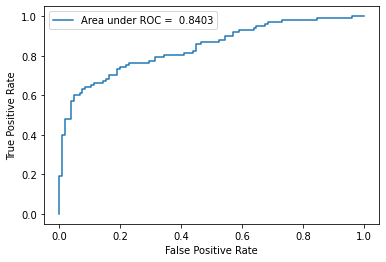

In [38]:
# plot the roc curve

fpr, tpr, _ = roc_curve(y_label, y_score)
plt.plot(fpr, tpr, label = 'Area under ROC = {: .4f}'.format(roc_score))
plt.legend(loc = 'best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

[Text(0, 0.5, 'CoViD'), Text(0, 1.5, 'NonCoViD')]

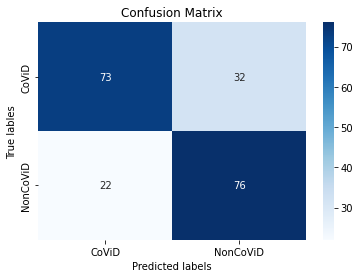

In [39]:
import seaborn as sns

conf_matrix = conf_matrix
ax= plt.subplot()
sns.heatmap(conf_matrix, annot= True, ax= ax, cmap = 'Blues') # annot = True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True lables')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['CoViD', 'NonCoViD'])
ax.yaxis.set_ticklabels(['CoViD', 'NonCoViD'])

In [40]:
# gradCAM 모듈 설치
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 13.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=d6fc6e2041babe1e4c3f3e66a0d8f6f6e6d6274857368eb909fd64e6a990869b
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [41]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image

test_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    lambda x: x[:3],
    transforms.Normalize(mean=[0,0,0], std=[1,1,1])
])

# gradCAM을 이용하여 활성화 맵(activation map)을 이미지 위에 시각화 하기
# model (torch.nn.module) : 학습된 모델 인스턴스
# class_ind (int) : 클래스 index (ex) 0 - NonCOVID / 1 - COVID
# img : 시각화 할 입력 이미지

def show_gradCAM(model, img):

  # target_layers = [model.layer4[-1]] #출력층 이전 마지막 레이어 가져오기
  target_layers = [model.model_image.features[-2][-1]]
  cam = GradCAM(model = model, target_layers= target_layers, use_cuda =True)

  inp = test_transformer(img).unsqueeze(0) # 입력 이미지 transform
  targets = [ClassifierOutputTarget(1)] # 타겟 지점
  grayscale_cam = cam(input_tensor = inp, targets = targets)
  grayscale_cam = grayscale_cam[0, :]

  # 활성화맵을 이미지 위에 표시
  visualization = show_cam_on_image(inp.squeeze(0).permute(1,2,0).numpy(), grayscale_cam, use_rgb=True)
  pil_image = Image.fromarray(visualization)
  return pil_image

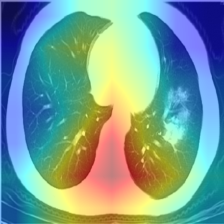

In [50]:
covid = Image.open(root_dir + 'Covid_Test/1_CT_COVID/Ni2020_Article_CombinationOfWesternMedicineAn-p3-10_0.png')
covid_cam = show_gradCAM(model, covid)
covid_cam